In [ ]:
!pip install imagecodecs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 46.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_images = '/LIVECell_Huh7/LIVECell_Huh7/images/train'
test_images = '/LIVECell_Huh7/LIVECell_Huh7/images/test'

train_path = "/LIVECell_Huh7/LIVECell_Huh7/train.json"
test_path = "/LIVECell_Huh7/LIVECell_Huh7/test.json"

traindata_path = "/content/drive" + "/MyDrive" + train_images
testdata_path = "/content/drive" + "/MyDrive" + test_images

traindrive_path = "/content/drive" + "/MyDrive" + train_path
testdrive_path = "/content/drive" + "/MyDrive" + test_path

In [ ]:
import pandas as pd
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import Any, Callable, List, Optional, Tuple
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import os

import torch
import torch.nn as nn
import torchvision.models.detection
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn


In [ ]:
# Load the JSON data into a Python list of dictionaries
data = []

with open(traindrive_path, 'r') as json_file:
    for line in json_file:
        record = json.loads(line)
        data.append(record)

df_s = pd.Series(data)

In [ ]:
for element in data:
    df = pd.DataFrame([element])
    keys = df.columns
    print("Keys within element:", keys)


# Iterate through each element in the Pandas Series
for element in data:
    # Access the "annotations" list within each element
    annotations_list = element.get("images", [])

    print("Annotations Keys within Element:")

    if annotations_list:
        # Assuming "annotations" contains at least one dictionary
        first_annotations = annotations_list[0]
        if isinstance(first_annotations, dict):
            # Access and print the keys within the first "annotations" dictionary
            annotations_keys = first_annotations.keys()
            print("Keys within 'images':", list(annotations_keys))

            annotations_keys = first_annotations.values()
            print("values within 'images':", list(annotations_keys))

    print()


# Iterate through each element in the Pandas Series
for element in data:
    # Access the "annotations" list within each element
    annotations_list = element.get("annotations", [])

    print("Annotations Keys within Element:")

    if annotations_list:
        # Assuming "annotations" contains at least one dictionary
        first_annotations = annotations_list[0]
        if isinstance(first_annotations, dict):
            # Access and print the keys within the first "annotations" dictionary
            annotations_keys = first_annotations.keys()
            print("Keys within 'annotations':", list(annotations_keys))

            annotations_keys = first_annotations.values()
            print("values within 'images':", list(annotations_keys))

    print()

# Iterate through each element in the Pandas Series
for element in data:
    # Access the "annotations" list within each element
    annotations_list = element.get("categories", [])

    print("categories Keys within Element:")

    if annotations_list:
        # Assuming "annotations" contains at least one dictionary
        first_annotations = annotations_list[0]
        if isinstance(first_annotations, dict):
            # Access and print the keys within the first "annotations" dictionary
            annotations_keys = first_annotations.keys()
            print("Keys within 'categories':", list(annotations_keys))

            annotations_keys = first_annotations.values()
            print("values within 'images':", list(annotations_keys))

    print()


Keys within element: Index(['images', 'annotations', 'categories'], dtype='object')
Annotations Keys within Element:
Keys within 'images': ['id', 'width', 'height', 'file_name', 'original_filename', 'url']
values within 'images': [1017382, 704, 520, 'Huh7_Phase_A10_2_03d04h00m_1.tif', 'Huh7_Phase_A10_2_03d04h00m_1.png', 'https://darwin.v7labs.com/api/images/870202/original']

Annotations Keys within Element:
Keys within 'annotations': ['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd']
values within 'images': [1017383, 1017382, 1, [[592.3, 266.24, 592.3, 266.88, 592.3, 269.9, 591.22, 272.7, 589.07, 277.01, 586.48, 283.68, 584.97, 289.07, 583.9, 292.3, 583.25, 297.47, 583.03, 307.38, 584.33, 314.92, 585.19, 319.22, 589.07, 328.27, 589.07, 332.8, 588.2, 334.73, 590.36, 337.96, 591.65, 337.96, 594.24, 339.26, 595.74, 340.77, 597.68, 345.72, 599.19, 349.81, 600.7, 353.26, 603.07, 356.92, 606.94, 359.07, 616.21, 364.24, 618.15, 365.97, 623.32, 367.91, 625.47, 367.91

In [ ]:
class LiveCellDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
# create own Dataset
my_dataset = LiveCellDataset(root=traindata_path, annotation=traindrive_path, transforms=get_transform())
test_dataset = LiveCellDataset(root=testdata_path, annotation=testdrive_path, transforms=get_transform())

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 1

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset, batch_size=train_batch_size, shuffle=True,
                                          num_workers=4, collate_fn=collate_fn)

test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=train_batch_size, shuffle=True,
                                          num_workers=4, collate_fn=collate_fn)


loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
loading annotations into memory...
Done (t=3.17s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
train_annotations = COCO(traindrive_path)
valid_annotations = COCO(testdrive_path)


cat_ids = train_annotations.getCatIds(catIds=[ ], catNms=[], supNms=["cell", "cell"])
train_img_ids = []
for cat in cat_ids:
    train_img_ids.extend(train_annotations.getImgIds(catIds=cat))

train_img_ids = list(set(train_img_ids))
print(f"Number of training images: {len(train_img_ids)}")

valid_img_ids = []
for cat in cat_ids:
    valid_img_ids.extend(valid_annotations.getImgIds(catIds=cat))

valid_img_ids = list(set(valid_img_ids))
print(f"Number of validation images: {len(valid_img_ids)}")

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
Number of training images: 390
Number of validation images: 216


In [ ]:
cat_ids

[1]

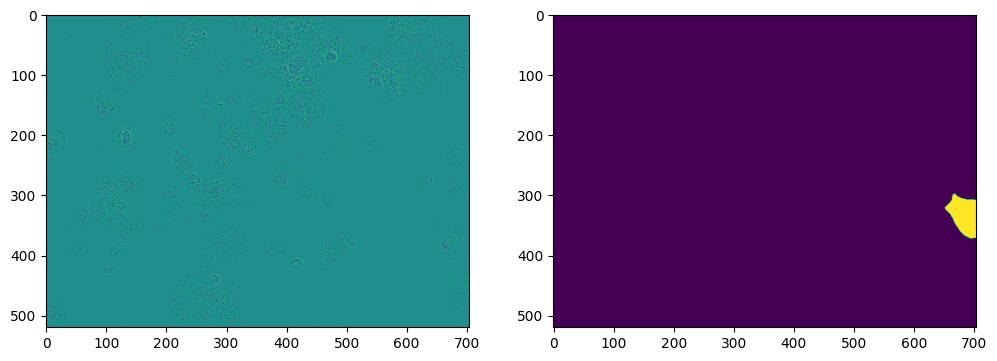

In [ ]:
i = 89
img_data = train_annotations.loadImgs(train_img_ids[i])
ann_ids = train_annotations.getAnnIds(imgIds=img_data[0]['id'], catIds=cat_ids, iscrowd=0)
anns = train_annotations.loadAnns(ann_ids)
# mask = np.max(np.stack([train_annotations.annToMask(ann) * ann["category_id"] for ann in anns]), axis=0)
# Create an empty array to store the stacked masks


# Iterate through annotations and combine masks
for ann in anns:
    mask = train_annotations.annToMask(ann) * ann["category_id"]

img = io.imread(str(traindata_path + '/' + img_data[0]["file_name"]))
img = img.astype('uint8')
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(TF.to_pil_image(img))

plt.subplot(122)
plt.imshow(mask)
plt.show()

In [ ]:
# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    # print(annotations)

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# 2 classes; Only target class or background
num_classes = 2
num_epochs = 1
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

Iteration: 1/390, Loss: 2.2231814861297607
Iteration: 2/390, Loss: 2.094808340072632
Iteration: 3/390, Loss: 1.9480736255645752
Iteration: 4/390, Loss: 2.413013219833374
Iteration: 5/390, Loss: 2.28083872795105
Iteration: 6/390, Loss: 2.0936241149902344
Iteration: 7/390, Loss: 2.192930221557617
Iteration: 8/390, Loss: 2.0430660247802734
Iteration: 9/390, Loss: 2.2918198108673096
Iteration: 10/390, Loss: 2.200319528579712
Iteration: 11/390, Loss: 1.964748501777649
Iteration: 12/390, Loss: 1.827133059501648
Iteration: 13/390, Loss: 1.2211111783981323
Iteration: 14/390, Loss: 1.238450288772583
Iteration: 15/390, Loss: 1.398508906364441
Iteration: 16/390, Loss: 1.3289222717285156
Iteration: 17/390, Loss: 0.9492316842079163
Iteration: 18/390, Loss: 1.671057105064392
Iteration: 19/390, Loss: 1.2810336351394653
Iteration: 20/390, Loss: 0.9907872080802917
Iteration: 21/390, Loss: 2.072131395339966
Iteration: 22/390, Loss: 1.9499584436416626
Iteration: 23/390, Loss: 1.9829347133636475
Iteration

In [ ]:
torch.save(model.state_dict(), 'maskrcnn_eca.pth')

In [ ]:
import time

# Set the model to evaluation mode
model.eval()

# Create a list to store inference times
inference_times = []

# Iterate over the evaluation dataset and measure inference time
for imgs, _ in data_loader:
    imgs = [img.to(device) for img in imgs]

    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        _ = model(imgs)
    end_time = time.time()

    # Calculate and record the inference time for this batch
    batch_inference_time = end_time - start_time
    inference_times.append(batch_inference_time)

# Calculate and print the average inference time
average_inference_time = sum(inference_times) / len(inference_times)
print(f'Average Inference Time: {average_inference_time:.4f} seconds')

# Now, you can compare the training and inference times
# print(f'Training Time: {training_time:.4f} seconds')
print(f'Inference Time: {average_inference_time:.4f} seconds')


Average Inference Time: 0.1178 seconds
Inference Time: 0.1178 seconds


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

def display_images_with_masks(images, targets, predictions=None):
    num_images = len(images)
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(12, 6 * num_images))

    for i in range(num_images):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Original Image')

        masks = targets[i]['masks'][0].cpu().numpy()  # Extract the first mask in the batch
        axes[i, 1].imshow(masks, cmap='viridis')
        axes[i, 1].set_title('Segmentation Mask')

    plt.show()


# Get a batch of test data (images and targets)
test_data = next(iter(test_data_loader))

# Extract images and targets
test_images = [img.to(device) for img in test_data[0]]
test_targets = test_data[1]

# Perform inference to get predictions (you need to adapt this to your setup)
with torch.no_grad():
    predictions = model(test_images)

# Display the test images with segmentation masks
display_images_with_masks(test_images, test_targets, predictions)


In [ ]:
test_data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Create a function to display images with segmentation masks
def display_images_with_masks(images, targets, predictions=None):
    num_images = len(images)
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(12, 6 * num_images))

    for i in range(num_images):
        image = images[i].cpu().numpy().any()
        plt.show(image[i])  # Assuming images are grayscale, adjust colormap if necessary
        plt.title('Segmentation Mask')


        masks = targets[i].cpu().numpy().any()
        axes[i, 1].imshow(masks, cmap='viridis')
        axes[i, 1].set_title('Segmentation Mask')

    plt.show()

# Assuming you already have test_images and test_targets
# Perform inference to get predictions (you need to adapt this to your setup)
if test_images and test_targets:
    # Perform inference to get predictions (you need to adapt this to your setup)
    with torch.no_grad():
        predictions = model(test_images)

    # Display the test images with segmentation masks
    display_images_with_masks(test_images, test_targets, predictions)
else:
    print("No test data available.")

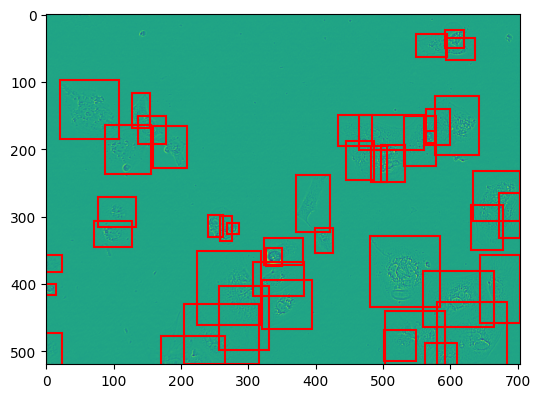

In [ ]:
from matplotlib import patches

images, labels = next(iter(test_data_loader))

def view(images, labels, n=2, std=1, mean=0):
    figure = plt.figure(figsize=(15, 10))
    images = list(images)
    labels = list(labels)
    num_samples = min(n, len(images))  # Ensure you don't access out-of-range indices

    for i in range(num_samples):
        out = torchvision.utils.make_grid(images[i])
        inp = out.cpu().numpy().transpose((1, 2, 0))
        inp = np.array(std) * inp + np.array(mean)
        inp = np.clip(inp, 0, 1)
        ax = figure.add_subplot(2, 2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
        if i < len(labels):
            l = labels[i]['boxes'].cpu().numpy()
            l[:, 2] = l[:, 2] - l[:, 0]
            l[:, 3] = l[:, 3] - l[:, 1]
            for j in range(len(l)):
                ax.add_patch(patches.Rectangle((l[j][0], l[j][1]), l[j][2], l[j][3], linewidth=1.5, edgecolor='r', facecolor='none'))

view(images=images, labels=labels, n=2, std=1, mean=0)


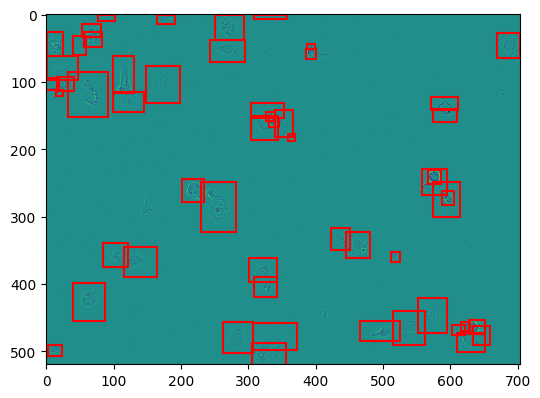

In [ ]:
# Set the model to evaluation mode
model.eval()

images, labels = next(iter(test_data_loader))

def view(images, labels, n=2, std=1, mean=0):
    figure = plt.figure(figsize=(15, 10))
    images = list(images)
    labels = list(labels)
    num_samples = min(n, len(images))  # Ensure you don't access out-of-range indices

    for i in range(num_samples):
        out = torchvision.utils.make_grid(images[i])
        inp = out.cpu().numpy().transpose((1, 2, 0))
        inp = np.array(std) * inp + np.array(mean)
        inp = np.clip(inp, 0, 1)
        ax = figure.add_subplot(2, 2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
        if i < len(labels):
            l = labels[i]['boxes'].cpu().numpy()
            l[:, 2] = l[:, 2] - l[:, 0]
            l[:, 3] = l[:, 3] - l[:, 1]
            for j in range(len(l)):
                ax.add_patch(patches.Rectangle((l[j][0], l[j][1]), l[j][2], l[j][3], linewidth=1.5, edgecolor='r', facecolor='none'))

# Call the view function
view(images=images, labels=labels, n=2, std=1, mean=0)


# 2 Train the same deep learning-based model but replace every ECA block by Squeeze-and-Excitation (SE) blocks.

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.se(x)
        return x * out

In [ ]:
def modify_resnet_backbone(resnet_backbone):
    # Replace a specific layer with SE block
    resnet_backbone.layer2[3].conv2 = SEBlock(in_channels=resnet_backbone.layer2[3].conv2.in_channels)

def get_se_model_instance_segmentation(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    model = fasterrcnn_resnet50_fpn(pretrained=False)

    # Modify the ResNet backbone to replace specific layers with SE blocks
    modify_resnet_backbone(model.backbone.body)

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
# 2 classes; Only target class or background
num_classes = 2
num_epochs = 1
model_se = get_se_model_instance_segmentation(num_classes)

# move model to the right device
model_se.to(device)

# parameters
params = [p for p in model_se.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model_se.train()
    i = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model_se(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')


Iteration: 1/390, Loss: 2.2834250926971436
Iteration: 2/390, Loss: 2.1216399669647217
Iteration: 3/390, Loss: 1.973393440246582
Iteration: 4/390, Loss: 2.020155906677246
Iteration: 5/390, Loss: 2.236037254333496
Iteration: 6/390, Loss: 2.063537359237671
Iteration: 7/390, Loss: 2.027298927307129
Iteration: 8/390, Loss: 1.953488826751709
Iteration: 9/390, Loss: 1.7329031229019165
Iteration: 10/390, Loss: 1.7260453701019287
Iteration: 11/390, Loss: 1.7574816942214966
Iteration: 12/390, Loss: 1.6739399433135986
Iteration: 13/390, Loss: 1.5281141996383667
Iteration: 14/390, Loss: 1.3961288928985596
Iteration: 15/390, Loss: 1.227344274520874
Iteration: 16/390, Loss: 1.009257435798645
Iteration: 17/390, Loss: 1.5794943571090698
Iteration: 18/390, Loss: 0.8576850295066833
Iteration: 19/390, Loss: 0.9663477540016174
Iteration: 20/390, Loss: 1.1278305053710938
Iteration: 21/390, Loss: 0.9910093545913696
Iteration: 22/390, Loss: 1.6742446422576904
Iteration: 23/390, Loss: 1.1300296783447266
Itera

In [ ]:
torch.save(model_se.state_dict(), 'maskrcnn_se.pth')

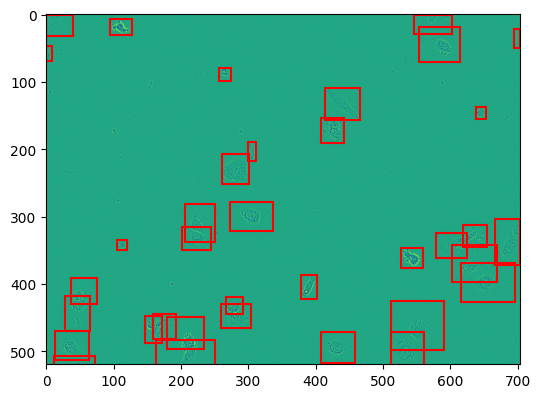

In [ ]:
# Set the model to evaluation mode
model_se.eval()

images, labels = next(iter(test_data_loader))

def view(images, labels, n=2, std=1, mean=0):
    figure = plt.figure(figsize=(15, 10))
    images = list(images)
    labels = list(labels)
    num_samples = min(n, len(images))  # Ensure you don't access out-of-range indices

    for i in range(num_samples):
        out = torchvision.utils.make_grid(images[i])
        inp = out.cpu().numpy().transpose((1, 2, 0))
        inp = np.array(std) * inp + np.array(mean)
        inp = np.clip(inp, 0, 1)
        ax = figure.add_subplot(2, 2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
        if i < len(labels):
            l = labels[i]['boxes'].cpu().numpy()
            l[:, 2] = l[:, 2] - l[:, 0]
            l[:, 3] = l[:, 3] - l[:, 1]
            for j in range(len(l)):
                ax.add_patch(patches.Rectangle((l[j][0], l[j][1]), l[j][2], l[j][3], linewidth=1.5, edgecolor='r', facecolor='none'))

# Call the view function
view(images=images, labels=labels, n=2, std=1, mean=0)

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Define the COCO evaluation function
def evaluate_coco(model, data_loader, device):
    model.eval()
    coco = COCO(testdrive_path)  # Replace with your COCO annotations file path
    coco_dt = []  # List to store model results

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for i, output in enumerate(outputs):
                image_id = targets[i]['image_id'].item()
                result = {
                    'image_id': image_id,
                    'category_id': output['labels'].cpu().numpy(),
                    'score': output['scores'].cpu().numpy(),
                    'bbox': output['boxes'].cpu().numpy(),
                }
                coco_dt.append(result)

    # Load model results into COCO format
    coco.cocoDt = coco.loadRes(coco_dt)

    # Create a COCO evaluation object
    coco_eval = COCOeval(coco.coco, coco.cocoDt, 'bbox')  # 'bbox' for bounding box evaluation

    # Set parameters for evaluation (optional):
    coco_eval.params.imgIds = sorted(coco.coco.getImgIds())  # Specify image IDs for evaluation
    coco_eval.params.catIds = sorted(coco.coco.getCatIds())  # Specify category IDs for evaluation

    # Run the evaluation
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

# Call the COCO evaluation function
evaluate_coco(model_se, test_data_loader, device)

# Visualize a few sample images with bounding boxes
images, labels = next(iter(test_data_loader))
view(images=images, labels=labels, n=2, std=1, mean=0)

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...


TypeError: ignored

In [ ]:
import time

# Set the model to evaluation mode
model_se.eval()

# Create a list to store inference times
inference_times = []

# Iterate over the evaluation dataset and measure inference time
for imgs, _ in test_data_loader:
    imgs = [img.to(device) for img in imgs]

    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        _ = model_se(imgs)
    end_time = time.time()

    # Calculate and record the inference time for this batch
    batch_inference_time = end_time - start_time
    inference_times.append(batch_inference_time)

# Calculate and print the average inference time
average_inference_time = sum(inference_times) / len(inference_times)
print(f'Average Inference Time: {average_inference_time:.4f} seconds')

# Now, you can compare the training and inference times
# print(f'Training Time: {training_time:.4f} seconds')
print(f'Inference Time: {average_inference_time:.4f} seconds')


In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.datasets import CocoDetection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader
from torchvision.utils import save_image

from PIL import Image
import os

# Define the COCO evaluation function
def evaluate_coco(model, data_loader, device, annotation_file):
    model.eval()
    coco = CocoDetection(root=testdata_path, annFile=annotation_file)
    with torch.no_grad():
        results = []
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            for i, output in enumerate(outputs):
                image_id = targets[i]['image_id'].item()
                result = {
                    "image_id": image_id,
                    "category_id": output['labels'].cpu().numpy().tolist(),
                    "score": output['scores'].cpu().numpy().tolist(),
                    "bbox": output['boxes'].cpu().numpy().tolist(),
                }
                results.append(result)

        coco.cocoDt = coco.coco.loadRes(results)
        coco.cocoEval = COCOeval(coco.coco, coco.cocoDt, "bbox")
        coco.cocoEval.params.imgIds = coco.coco.getImgIds()
        coco.cocoEval.evaluate()
        coco.cocoEval.accumulate()
        coco.cocoEval.summarize()

# Load your trained ECA model
model_eca = get_model_instance_segmentation(num_classes=num_classes)

# Load the ECA model weights
model_eca.load_state_dict(torch.load('/content/maskrcnn_eca.pth'))
model_eca.to(device)

# Call the evaluation function for ECA model
evaluate_coco(model_eca, test_data_loader, device, testdrive_path)

# Load your trained SE model
model_se = get_se_model_instance_segmentation(num_classes=num_classes)

# Load the SE model weights
model_se.load_state_dict(torch.load('/content/maskrcnn_se.pth'))
model_se.to(device)

# Call the evaluation function for SE model
evaluate_coco(model_se, test_data_loader, device, testdrive_path)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RuntimeError: ignored

# Visualize the segmentation results

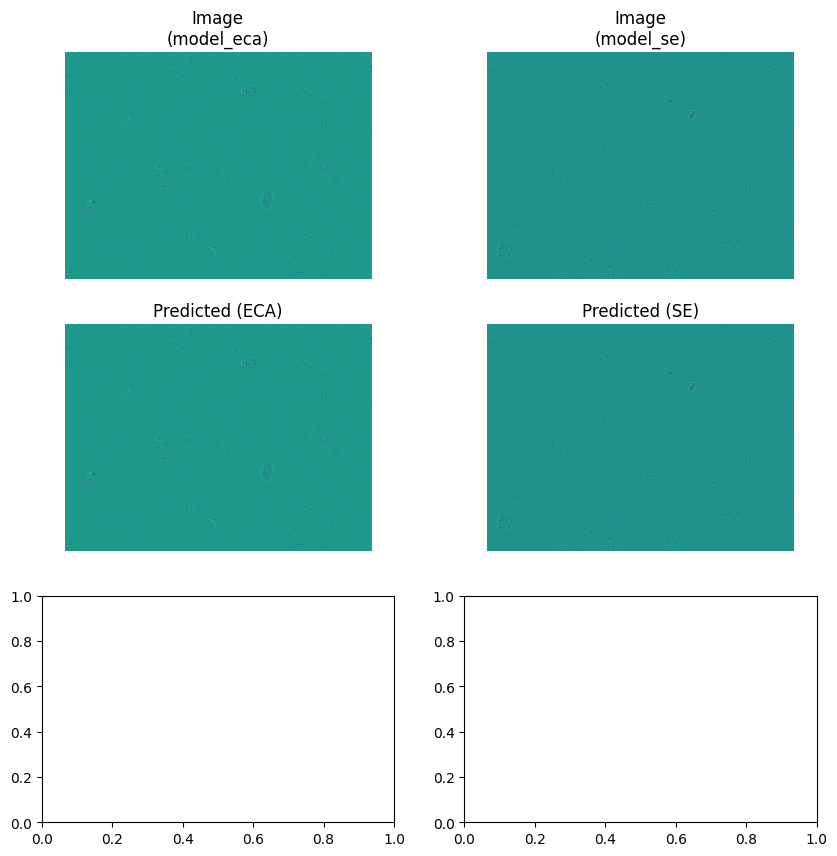

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Create a function to display images and masks
def display_images_and_masks(images, masks, model_names, titles):
    n = len(images)
    rows = 3
    cols = n // 3
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 10))
    # fig, axes = plt.subplots(2, n, figsize=(5 * n, 10))

    for i, (image, mask, model_name, title) in enumerate(zip(images, masks, model_names, titles)):

        row = i // cols
        col = i % cols
        ax = axes[row, col]
        image = image[0]
        ax.imshow(image[0])
        ax.axis('off')
        ax.set_title(f'Image\n({model_name})')

        ax = axes[row + 1, col]
        mask = mask[0]
        ax.imshow(mask[0])
        ax.axis('off')
        ax.set_title(title)


    plt.show()

# Define the transform to convert the output masks to binary
mask_transform = T.Compose([T.ToPILImage(), T.ToTensor()])

# Collect samples for visualization
num_samples = 6

samples_eca = []
samples_se = []

for i, (image, target) in enumerate(test_dataset):
    if i >= num_samples:
        break

    image_tensor = image.unsqueeze(0).to(device)

    # Make predictions using both models
    with torch.no_grad():
        prediction_eca = model_eca(image_tensor)[0]
        prediction_se = model_se(image_tensor)[0]

    # Convert the predictions to binary masks
    mask_eca = mask_transform(prediction_eca['boxes']).numpy()
    mask_se = mask_transform(prediction_se['boxes']).numpy()


    samples_eca.append((image, mask_eca, 'model_eca', 'Predicted Mask (ECA)'))
    samples_se.append((image, mask_se, 'model_se', 'Predicted Mask (SE)'))

# Visualize the samples
display_images_and_masks(samples_eca, samples_se, ['model_eca', 'model_se'], ['Predicted (ECA)', 'Predicted (SE)'])